In [1]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image

from keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.utils import class_weight

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image, display

import pandas as pd

import tqdm
from collections import Counter
from keras.models import model_from_json

In [2]:
#Path where are the project
path_original = ""

### Sepair folds

In [3]:
#Reading the file with the BPI information (Target, Match and Frames)
all_games = pd.read_csv('all_games_other_games.csv')

#Geting the target values
y = all_games[all_games['interval_frame_size'] >= 500].target

#Selecting only BPI with 500 or more frames (15 seg)
partidas = pd.DataFrame(all_games[all_games['interval_frame_size'] >= 500].partida)

#Reseting the index of dataframe (to follow the original data)
partidas.reset_index(inplace=True)
partidas.drop(['index'],axis=1, inplace=True)

In [4]:
#Reading the multi channel imagens
data = np.load('multi_chanel_imagens.npy')

In [5]:
data.shape

(66, 11, 167, 16)

In [6]:
data[0].shape

(11, 167, 16)

### Original fold

In [7]:
#Reading file with fold information
game_folds = pd.read_csv(f'{path_original}games_fold_ad.csv',index_col=[0])

In [8]:
#Dados de Teste

games_list_test = []#Lista com o nome das partidas de cada fold
for fold in range(game_folds.columns.size - 1):
    games_names_test = game_folds[(game_folds['turn_'+str(fold)] == 15)].partida.values 
    #Pegando todas as partidas para treinamento
                                                                                    
    games_list_test.append(games_names_test)
    
idx_folds_test = [] #Lista do idx de cada fold do grid search
for fold_idx in range(len(games_list_test)):
    idx_folds_test.append(partidas[partidas.apply(lambda x: x.partida in games_list_test[fold_idx],
                                                          axis=1)].index.values)

In [9]:
#Dados de Treino

#Separa os nome de todas as partidas que NAO serão teste nas rodadas
games_list = []#Lista com o nome das partidas de cada fold
for fold in range(game_folds.columns.size - 1):
    games_names = game_folds[(game_folds['turn_'+str(fold)] != 15)].partida.values #Pegando todas as partidas para treinamento
                                                                                    
    games_list.append(games_names)
    
idx_folds = [] #Lista do idx de cada fold do grid search
for fold_idx in range(len(games_list)):
    idx_folds.append(partidas[partidas.apply(lambda x: x.partida in games_list[fold_idx], axis=1)].index.values)  

### Creating de CNN

In [10]:
from tensorflow import keras
from keras import metrics
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras import optimizers

In [11]:
model_conv = models.Sequential()

#CNN
model_conv.add(keras.layers.Conv2D(16, kernel_size=(2,2), name='conv1', activation='relu'))

model_conv.add(keras.layers.BatchNormalization())
model_conv.add(keras.layers.Conv2D(32, kernel_size=(2,2), name='conv2', activation='relu'))

model_conv.add(keras.layers.Reshape((32, 495, 3)))

#Transfer Leraning
model_conv.add(EfficientNetB0(weights='imagenet', include_top=False, pooling='avg'))

#MLP
model_conv.add(keras.layers.Dense(1280, activation="relu", kernel_initializer="he_uniform",
                                  name="hidden1"))

model_conv.add(keras.layers.Dropout(0.5))
model_conv.add(keras.layers.Dense(640, activation="relu", kernel_initializer="he_uniform",
                                  name="hidden2"))

model_conv.add(keras.layers.Dropout(0.2))
model_conv.add(keras.layers.Dense(320, activation="relu", kernel_initializer="he_uniform",
                                  name="hidden3", kernel_regularizer=keras.regularizers.l2(1e-3)))

model_conv.add(keras.layers.Dropout(0.2))
model_conv.add(keras.layers.Dense(160, activation="relu", kernel_initializer="he_uniform",
                                  name="hidden4", kernel_regularizer=keras.regularizers.l2(1e-3)))

model_conv.add(keras.layers.Dense(2, activation="softmax", name ="decision"))

In [12]:
def get_class_weight(y):
    """
    Recives a array with the class, and return a dict with weights for each.
    """
    weights = class_weight.compute_class_weight(class_weight='balanced', 
                                            classes =np.unique(y), 
                                            y=y)

    class_weights = {0:weights[0], 1:weights[1]}
    return class_weights 

In [13]:
#Metrics to calculate the balanced acc during the training

def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def specificity_m(y_true, y_pred):
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity

def balanced_acc(y_true, y_pred):
    ba = (recall(y_true, y_pred) + specificity_m(y_true, y_pred)) * 0.5  
    
    return ba

#Define the name for balanced_accuracy in the fit
balanced_acc.__name__ = 'ba'

In [14]:
def get_data(fold):
    '''
    Get the data for training and test for multi channel images (11x167x16)
    '''
    #Selecting the training data
    y_train = y.iloc[idx_folds[fold]].values
    y_train_d = keras.utils.to_categorical(y_train, num_classes = 2)
    X_train = data[idx_folds[fold]]

    #Define the weights of each class
#     weights = get_class_weight(y_train)
#     class_weights = {0:weights[0], 1:weights[1]}

    #Seting the test index od the fold
    X_test = data[idx_folds_test[fold]]
    y_test = y.iloc[idx_folds_test[fold]].values
    y_test_d = keras.utils.to_categorical(y_test, num_classes = 2)
    
    print(f'Leaked data?:{np.unique([index in idx_folds_test[fold] for index in idx_folds[fold]])}')

    return X_train, y_train, y_train_d, X_test, y_test, y_test_d

In [15]:
def save_model(model, path_save):
    
    # serialize model to JSON
    model_json = model.to_json()
    with open(f"{path_save}CNN_EfficientB0.json", "w") as json_file:
        json_file.write(model_json)
        
    # serialize weights to HDF5
    model.save_weights(f"{path_save}CNN_EfficientB0.h5")
    
    #Second way to save
    model_conv.save(f'{path_save}CNN_EfficientB0')
    print("Saved model to disk")

In [16]:
def evalute_model(model, X_test, y_test, y_test_d):
    '''
    Return the balanced acc for the passed model with the test data
    '''
    predict = model.predict(X_test)
    predict_class =[np.argmax(value) for value in predict]
    ba = balanced_accuracy_score(y_test, predict_class)
    
    print(f'Balanced Acc: {ba}')
    
    score = model.evaluate(X_test, y_test_d, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
    
    print(f'Total of each class predicted: {Counter(predict_class)}\n')

    tn, fp, fn, tp = confusion_matrix(y_test, predict_class).ravel()
    print(f' True Positive: {tp}\n True Negative: {tn}\n False Positive: {fp}\n False Negative: {fn}\n')
    
    return ba

### Training the CNN

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

0 {0: 1, 1: 3}
Training fold: 0
Leaked data?:[ True]
Balanced Acc: 0.5
ba: 72.92%
Total of each class predicted: Counter({0: 66})

 True Positive: 0
 True Negative: 62
 False Positive: 0
 False Negative: 4



F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: modelos_reviewed/CNN_03/0/CNN_EfficientB0\assets


F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Saved model to disk
INFO:tensorflow:Assets written to: modelos_reviewed/CNN_03/0/CNN_EfficientB0\assets


F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
 10%|████████▏                                                                         | 1/10 [03:05<27:50, 185.56s/it]

Training fold: 1
Leaked data?:[ True]
Balanced Acc: 0.5
ba: 27.08%
Total of each class predicted: Counter({1: 66})

 True Positive: 4
 True Negative: 0
 False Positive: 62
 False Negative: 0



F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: modelos_reviewed/CNN_03/1/CNN_EfficientB0\assets


F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Saved model to disk
INFO:tensorflow:Assets written to: modelos_reviewed/CNN_03/1/CNN_EfficientB0\assets


F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
 20%|████████████████▍                                                                 | 2/10 [06:33<26:27, 198.47s/it]

Training fold: 2
Leaked data?:[ True]
Balanced Acc: 0.5403225806451613
ba: 29.53%
Total of each class predicted: Counter({1: 61, 0: 5})

 True Positive: 4
 True Negative: 5
 False Positive: 57
 False Negative: 0



F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: modelos_reviewed/CNN_03/2/CNN_EfficientB0\assets


F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Saved model to disk
INFO:tensorflow:Assets written to: modelos_reviewed/CNN_03/2/CNN_EfficientB0\assets


F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
 30%|████████████████████████▌                                                         | 3/10 [10:04<23:52, 204.60s/it]

Training fold: 3
Leaked data?:[ True]
Balanced Acc: 0.5241935483870968
ba: 28.65%
Total of each class predicted: Counter({1: 63, 0: 3})

 True Positive: 4
 True Negative: 3
 False Positive: 59
 False Negative: 0



F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: modelos_reviewed/CNN_03/3/CNN_EfficientB0\assets


F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Saved model to disk
INFO:tensorflow:Assets written to: modelos_reviewed/CNN_03/3/CNN_EfficientB0\assets


F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
 40%|████████████████████████████████▊                                                 | 4/10 [13:16<19:57, 199.60s/it]

Training fold: 4
Leaked data?:[ True]
Balanced Acc: 0.5
ba: 27.21%
Total of each class predicted: Counter({1: 66})

 True Positive: 4
 True Negative: 0
 False Positive: 62
 False Negative: 0



F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: modelos_reviewed/CNN_03/4/CNN_EfficientB0\assets


F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Saved model to disk
INFO:tensorflow:Assets written to: modelos_reviewed/CNN_03/4/CNN_EfficientB0\assets


F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
 50%|█████████████████████████████████████████                                         | 5/10 [16:16<16:01, 192.23s/it]

Training fold: 5
Leaked data?:[ True]
Balanced Acc: 0.5080645161290323
ba: 27.45%
Total of each class predicted: Counter({1: 65, 0: 1})

 True Positive: 4
 True Negative: 1
 False Positive: 61
 False Negative: 0



F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: modelos_reviewed/CNN_03/5/CNN_EfficientB0\assets


F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Saved model to disk
INFO:tensorflow:Assets written to: modelos_reviewed/CNN_03/5/CNN_EfficientB0\assets


F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
 60%|█████████████████████████████████████████████████▏                                | 6/10 [19:16<12:32, 188.12s/it]

Training fold: 6
Leaked data?:[ True]
Balanced Acc: 0.5
ba: 27.09%
Total of each class predicted: Counter({1: 66})

 True Positive: 4
 True Negative: 0
 False Positive: 62
 False Negative: 0



F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: modelos_reviewed/CNN_03/6/CNN_EfficientB0\assets


F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Saved model to disk
INFO:tensorflow:Assets written to: modelos_reviewed/CNN_03/6/CNN_EfficientB0\assets


F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [22:06<09:06, 182.15s/it]

Training fold: 7
Leaked data?:[ True]
Balanced Acc: 0.5
ba: 27.10%
Total of each class predicted: Counter({1: 66})

 True Positive: 4
 True Negative: 0
 False Positive: 62
 False Negative: 0



F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: modelos_reviewed/CNN_03/7/CNN_EfficientB0\assets


F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Saved model to disk
INFO:tensorflow:Assets written to: modelos_reviewed/CNN_03/7/CNN_EfficientB0\assets


F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [25:03<06:01, 180.78s/it]

Training fold: 8
Leaked data?:[ True]
Balanced Acc: 0.8588709677419355
ba: 71.88%
Total of each class predicted: Counter({0: 61, 1: 5})

 True Positive: 3
 True Negative: 60
 False Positive: 2
 False Negative: 1



F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: modelos_reviewed/CNN_03/8/CNN_EfficientB0\assets


F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Saved model to disk
INFO:tensorflow:Assets written to: modelos_reviewed/CNN_03/8/CNN_EfficientB0\assets


F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [28:02<03:00, 180.02s/it]

Training fold: 9
Leaked data?:[ True]
Balanced Acc: 0.5
ba: 27.08%
Total of each class predicted: Counter({1: 66})

 True Positive: 4
 True Negative: 0
 False Positive: 62
 False Negative: 0



F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: modelos_reviewed/CNN_03/9/CNN_EfficientB0\assets


F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Saved model to disk
INFO:tensorflow:Assets written to: modelos_reviewed/CNN_03/9/CNN_EfficientB0\assets


F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [30:58<00:00, 185.82s/it]


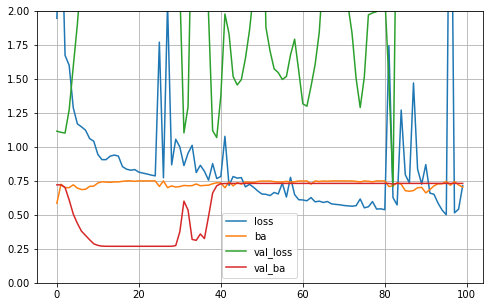

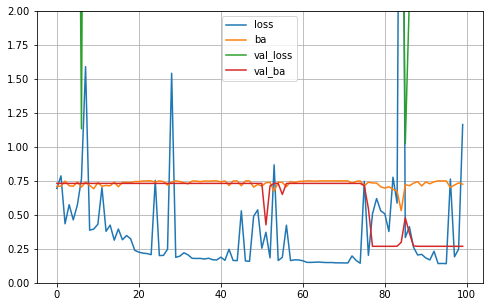

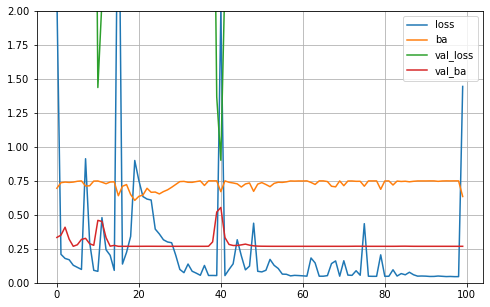

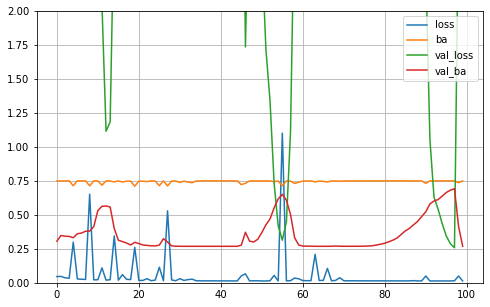

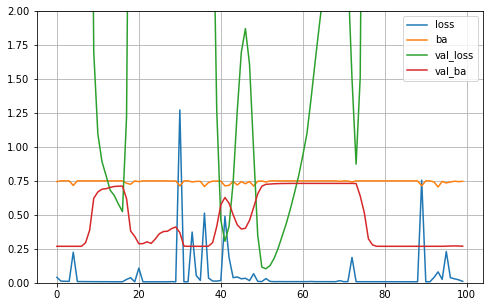

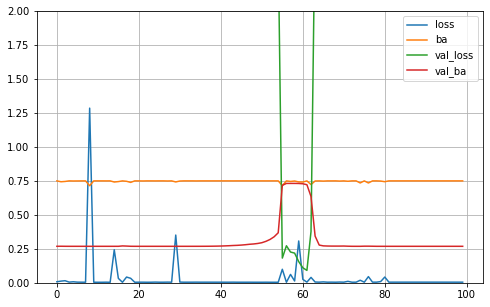

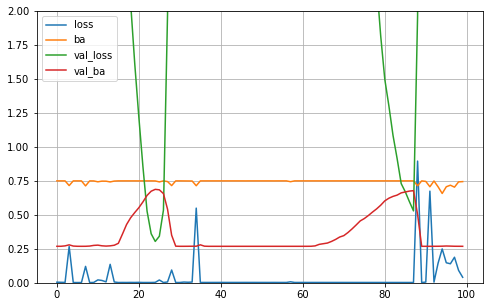

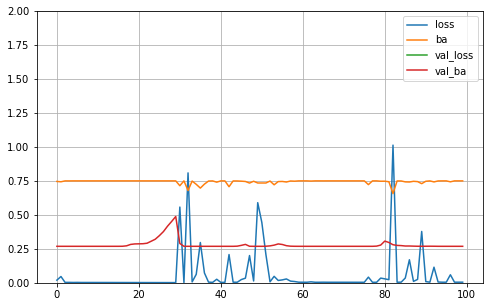

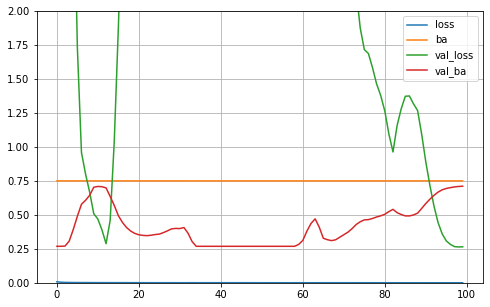

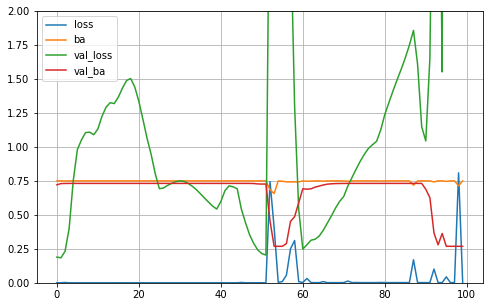

In [17]:
#List of weight that will be tested in the network
list_class_weights = [{0:1, 1:3}]

#Name of fold that will save the model
clas_weight = ['03']

for indx_class_weight, class_weight in enumerate(list_class_weights):
    
    print(indx_class_weight, class_weight)
    CNN_fold = f'CNN_{clas_weight[indx_class_weight]}'

    list_x_test = []
    list_y_test = []
    list_y_test_d = []

    for i in tqdm.tqdm(range(10)):

        fold = i
        print(f'Training fold: {fold}')

        #Create the partition to save the model and weights
        path_save = f'modelos_reviewed/{CNN_fold}/{fold}/'
        os.makedirs(path_save, exist_ok=True)

        X_train, y_train, y_train_d, X_test, y_test, y_test_d = get_data(fold)

        list_x_test.append(X_test)
        list_y_test.append(y_test)
        list_y_test_d.append(y_test_d)

        keras.backend.clear_session()
        opt =  keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)

        model_conv.compile(loss="categorical_crossentropy", 
                           optimizer=opt,
                           metrics=[balanced_acc])

        num_epochs = 100

        history = model_conv.fit(X_train,
                             y_train_d,
                             epochs = num_epochs,
                             validation_split=0.4,
                             verbose = 0,
                             batch_size=32,
                             use_multiprocessing=True,
                             class_weight=class_weight)

        evalute_model(model_conv, X_test, y_test, y_test_d)

        #Saving the model
        save_model(model_conv, path_save)
        
        #https://www.tensorflow.org/guide/keras/save_and_serialize#whole-model_saving_loading
        model_conv.save(f'{path_save}CNN_EfficientB0')
    #     model_conv.save(f'{path_save}CNN_EfficientB0.h5')

        #Saving the graph od imagens
        pd.DataFrame(history.history).plot(figsize=(8, 5))
        plt.grid(True)
        plt.gca().set_ylim(0, 2)
        #     plt.show()
        plt.savefig(f"{path_save}CNN_{fold}.svg")